# Parameters and Parameterized objects

Fundamentally, what Param does is allow you to control how certain crucial attributes ("parameters") of a Python class or instance will behave when their value is get or set. A user of that class can set those attributes to control the class, but only if the mechanisms provided by Param and configured by the programmer allow it. In this way, Param allows the author of a class to implement and constrain what a user can do with that class or an instance of it, setting up a clear contract of what is and is not allowed, and how that attribute will behave. To do this, Param provides two main new types of Python object: `Parameter` objects, and `Parameterized` objects.

A parameter is a special kind of Python class attribute.  Setting a `Parameterized` class attribute to be a Parameter instance causes that attribute of the class (and the class's instances) to be treated as a parameter, not just an ordinary attribute. Parameters support special behavior, including dynamically generated parameter values, documentation strings, constant and read-only parameters, type or range checking at assignment time, and values dependent on those of other parameters.

More concretely, a Python `Parameter` object inherits from `param.Parameter` and stores various metadata attributes describing how a corresponding Python attribute of a `Parameterized` object should behave. By convention, we will use a capital 'P' Parameter to refer to the Parameter object itself, and a lower-case 'p' parameter to refer to the Python attribute it controls. 

A `Parameterized` class is a Python class that inherits from `param.Parameterized` and can accept `Parameter` objects as class attributes. A `Parameterized` class or instance uses the `Parameter` objects to determine how the corresponding attribute should behave.

There are many specific types of `Parameter` with different behavior, discussed in [Parameter Types](Parameter_Types.ipynb), but here we will cover the common behavior between _all_ Parameter types when used in a `Parameterized` object.

### Parameter metadata

Each Parameter type can define additional behavior and associated metadata, but the metadata supported for all Parameter types includes:

- **default**: Default value for this parameter at the class level, which will also be the value at the Parameterized instance level if it hasn't been set separately on the instance.
- **name**: String **name** of this parameter, which is typically determined by the attribute name of this Parameter in the owning Parameterized object, and is not set directly by a programmer.
- **label**: Optional long name used for a verbose listing; defaults to the **name**.
- **allow_None**: Whether this parameter accepts None as an allowed value, in addition to whatever other types it accepts. Automatically set to True if the default value of this Parameter is None.
- **doc**: Docstring describing this parameter, which can be used by automatic documentation systems.
- **constant**: Parameter whose value can only be changed at the class level or in a Parameterized constructor; the value is constant once the Parameterized instance is created.
- **readonly**: Parameter whose value cannot be set by a user either on an instance or at the class level. Can still be changed inside a codebase by temporarily overriding this value, e.g. to report internal state
- **instantiate**: Whether to deepcopy the default value into a Parameterized instance when it is created. 
- **per_instance**: whether a separate Parameter instance will be created for every Parameterized instance created.
- **precedence**: Optional numeric value controlling whether this parameter is visible in a listing and if so in what order.

Most of these settings (apart from **name**) are accepted as keyword arguments to the Parameter's constructor, with `default` also accepted as a positional argument:

In [ ]:
import param
from param import Parameter, Parameterized

p = Parameter(42, doc="The answer", constant=True)
p.default

In [ ]:
p.allow_None

In [ ]:
p.doc

## Parameter objects and instances

In most cases, a Parameter will not be declared on its own as above; the Parameter object by itself is little more than a container for the metadata above. Until it is put into a class, most of those declarations are not meaningful, because what the Parameter object does is to specify how the corresponding Python attribute of that class should be handled. For example, we can define a Parameterized class with a couple of Parameter objects, and we'll then be able to access the corresponding attributes of that class:

In [ ]:
class A(Parameterized):
    question = Parameter("What is it?", doc="The question")
    answer = Parameter(2, constant=True, doc="The answer")
    ultimate_answer = Parameter(42, readonly=True, doc="The real answer")

a = A(question="How is it?", answer="6")

Here, we created a Parameterized class `A`, with parameters `question` and `answer`, each with default values. We then instantiated a Python object `a` of type `A`. Without having to write a constructor for `A`, we were able to provide our own values for `question` and `answer`, while inheriting the default value of `ultimate_answer`. This approach gives a lot (but not too much!) of configurability to the user of this class, without much effort by the class author. Any values we provide at instantiation need to be allowed by the `Parameter` declaration; e.g. here we could not provide a value for `ultimate_answer` when declaring `a`, because that parameter is read only.

In [ ]:
with param.exceptions_summarized():
    A(ultimate_answer="no")

Now that we have a Parameterized instance `a`, we can access the attributes we defined just as if they were normal Python instance attributes, and we'll get the values we provided:

In [ ]:
a.question

In [ ]:
a.answer

Meanwhile, the `Parameterized` _class_ `A` (not the instance `a`) still has the default values, accessible as class attributes and used for any future objects instantiated of type `A`:

In [ ]:
A.question

In [ ]:
A.answer

In [ ]:
b=A()
b.answer

If accessing the attribute always gives us a value whether on the instance or the class, what happened to the `Parameter` objects? They are stored on the Parameterized instance or class, and are accessible via a `param` accessor object at either the instance or class levels:

In [ ]:
a.param.question

In [ ]:
a.param.question.name

In [ ]:
a.param.question.default

In [ ]:
A.param.question.default

Once the Parameterized instance is created, the attributes can continue to be modified on it as often as you like, as long as the value is allowed by the `Parameter` object involved. E.g. `question` can still be changed, while `answer` is constant and cannot be changed after the `Parameterized` object has been instantiated:

In [ ]:
with param.exceptions_summarized():
    a.question=True
    a.answer=5

In [ ]:
a.question

In most cases, the only time you need to worry about the Parameter is when you first declare it; after that it will sit there happily behaving as instructed, noticeable only when a user attempts something the declarer of that Parameter has not allowed. You can safely leave the various metadata items at their defaults most of the time, but they are all there for when your particular application requires a certain behavior.  

## Parameter inheritance and instantiation

Much of the parameter metadata is there to help you control whether and how the parameter value is instantiated on Parameterized objects as they are created or new Parameterized subclasses as they are defined. Depending on how you want to use that Parameter and what values it might take, controlling instantiation can be very important when mutable values are involved. First, let's look at the default behavior, which is appropriate for immutable attributes:

In [ ]:
class B(A):
    ultimate_answer = Parameter(84, readonly=True)

b = B()
b.question

In [ ]:
A.question="How are you?"

In [ ]:
b.question

Here you can see that B inherits the `question` parameter from A, and as long as `question` has not been set explicitly on `b`, `b.question` will report the value from where that Parameter was defined, i.e. A in this case. If `question` is subsequently set on `b`, `b.question` will no longer be affected by the value in `A`:

In [ ]:
b.question="Why?"
A.question="Who?"
b.question

As you can see, parameters not specified in B are still fully usable in it, if they were declared in a superclass. Metadata associated with that parameter is also inherited if not explicitly overidden in `B`. E.g. `help(b)` or  `help(B)` will list all parameters:

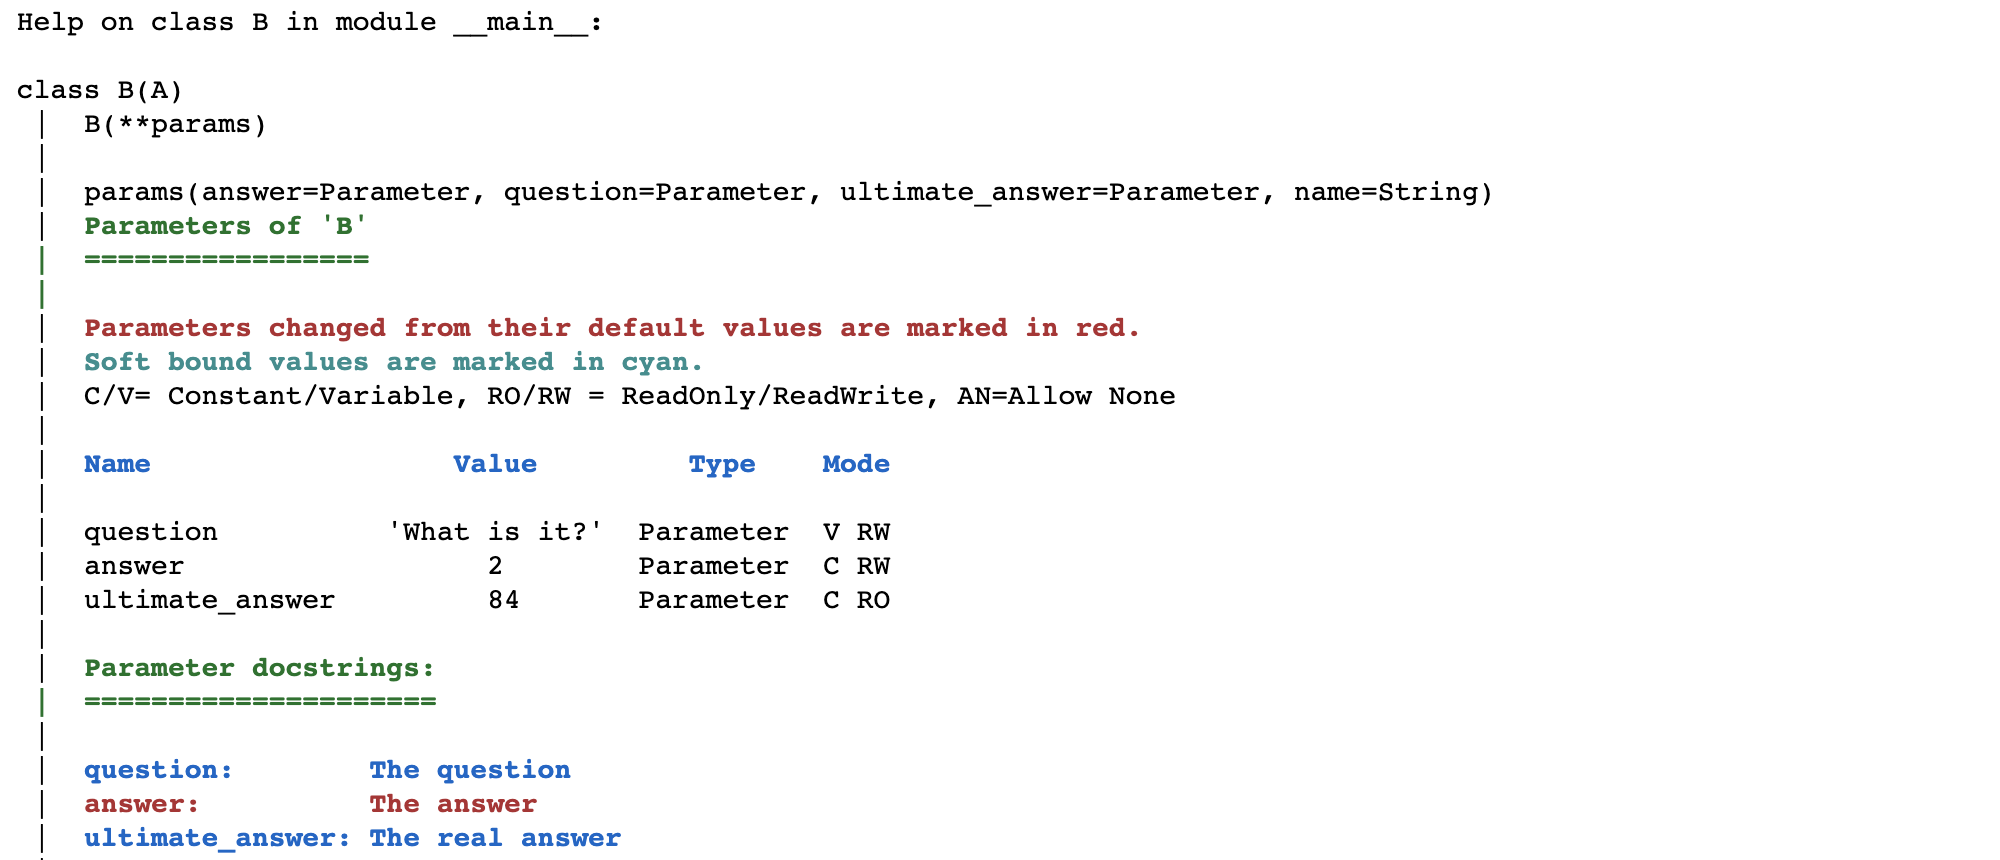

Parameter inheritance like this lets you (a) define a Parameter only once, no matter how many subclasses it might be used in, and (b) control the value of that parameter conveniently across the entire set of subclasses and instances, as long as that attribute has not been set on those objects already. Using inheritance in this way is a very convenient mechanism for setting default values and other "global" parameters, whether before a program starts executing or during it.

However, what happens if the value (unlike Python strings) is mutable? Things get a lot more complex:

In [ ]:
s = [1,2,3]

class C(Parameterized):
    s1 = param.Parameter(s, doc="A sequence")
    s2 = param.Parameter(s, doc="Another sequence")

c = C()

Here, both parameters `s1` and `s2` effectively point to the same underlying sequence `s`:

In [ ]:
c.s1 is c.s2

In [ ]:
s[1]*=5

In [ ]:
s

In [ ]:
c.s1

In [ ]:
c.s1[2]='a'

In [ ]:
c.s1

In [ ]:
c.s2

As you can see, there is only one actual sequence here, and `s`, `s1`, and `s2` all point to it. In some cases such behavior is desirable, e.g. if the mutable object is a specific global list (e.g. a set of search paths) with a unique identity and all of the parameters are meant to point to that specific item. In other cases, it's the contents of the mutable item that are important, and no sharing of contents is intended. Luckily, Param supports that case as well, if you provide `instantiate=True`:

In [ ]:
s = [1,2,3]

class D(Parameterized):
    s1 = Parameter(s, doc="A sequence", instantiate=True)
    s2 = Parameter(s, doc="Another sequence", instantiate=True)

d = D()

Now, parameters `s1` and `s2` point to their own copies of the sequence, independent of each other and of the original argument `s`:

In [ ]:
d.s1 is d.s2

In [ ]:
s*=2

In [ ]:
s

In [ ]:
d.s1

In [ ]:
d.s1[2]='a'

In [ ]:
d.s2

Of course, copying the data into each instance like that costs memory, and moreover prevents controlling all instances at once by setting a class attribute as we saw earlier, which is why `instantiate` is not True by default. As a rule of thumb, set `instantiate=True` if and only if (a) your Parameter can take mutable values, and (b) you want those values to be independent between Parameterized instances.

## Parameter metadata inheritance and instantiation

`instantiate` controls how parameter values behave, but similar issues arise for Parameter objects, which offer similar control via the `per_instance` metadata declaration. `per_instance` (True by default) provides a logically distinct Parameter object for every Parameterized instance, allowing each such instance to have different metadata for that parameter. For example, we can set the label separately for each instance without clobbering each other:

In [ ]:
d1 = D()
d2 = D()
d1.param.s1.label="sequence 1"
d2.param.s1.label="Sequence 1"
d2.param.s1.label

In [ ]:
d1.param.s1.label

This capability is useful for situations with dynamically updated metadata, e.g. if you need setting one parameter's value (e.g. 'Continent') to change the allowed values of another parameter (e.g. 'Country'). The underlying Parameter objects are copied lazily (only when actually changed), so that objects are not actually multiplied unless necessary. If you do want parameters to share a single Parameter object so that you can control its behavior globally, you can achieve that with `per_instance=False`, though the effects are confusing in the same way as `instantiate=True` for mutable objects (above):

In [ ]:
class E(Parameterized):
    a = param.Parameter(3.14, label="pi", per_instance=False)

e1 = E()
e2 = E()
e2.param.a.label="Pie"
e1.param.a.label

## Parameterized methods

Most of the important behavior of Parameterized is to do with instantiation, getting, and setting, as described above. Parameterized also provides a few public methods for creating a string representation of the Parameterized object and its parameters:

- `Parameterized.__str__()`: A concise, non-executable representation of the name and class of this object
- `Parameterized.__repr__()`: A representation of this object and its parameter values as if it were a constructor call (`classname(parameter1=x,parameter2=y,...)`)
- `Parameterized.pprint()`: Hierarchical pretty-printed representation of this Parameterized and (recursively) any of its parameters that are Parameterized objects
- `Parameterized.script_repr()`: Same as pprint, for backwards compatibility

The remaining "utility" or convenience methods available for a `Parameterized` class or object are provided via a subobject called `param` that helps keep the namespace clean and disambiguate between Parameter objects and parameter values:

- `.param.print_param_defaults()`: Print the default values of all parameters in this class
- `.param.set_default(param_name,value)`: Set the default value of the given parameter, which is equivalent to setting `param_name` at the class level.
- `.param._add_parameter(param_name,param_obj)`: Dynamically add a new Parameter to this object's class
- `.param.params(parameter_name=None)`: Parameter objects of this class (and superclasses) as the dictionary `{name: parameter_object}`
- `.param.set_param(*args,**kwargs)`: Set parameter values in a batch of `param=value` keyword arguments, delaying watching and dependency handling until all have been updated
- `.param.objects(instance=True)`: Parameter objects of this instance or class
- `.param.get_param_values(onlychanged=False)`: A list of name,value pairs for all parameters of this object
- `.param.get_value_generator(name)`: Returns the underlying value-generating callable for this parameter, or the underlying static value if none
- `.param.force_new_dynamic_value(name)`: For a Dynamic parameter, generate a new value and return it
- `.param.inspect_value(name)`: For a Dynamic parameter, return the current value of the named attribute without modifying it.
- `.param.params_depended_on(self_,name)`: A list of all parameters that the indicated parameter depends on
- `.param.defaults()`: Dictionary {parameter_name:parameter.default} for all non-constant parameters
- `.param.print_param_values()`: Print out the values for all this object's parameters.
